### Import libs

In [1]:
import sys, os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle as pk

import keras
import tensorflow
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import BatchNormalization, ReLU, Reshape, Input, InputLayer, Dropout

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

### Parameters

Colors and labels

In [2]:
dict_colors = {
               0: 'mediumspringgreen',
               1: 'indianred',
               2: 'red',
               3: 'chocolate',
               4: 'gold',
               5: 'yellowgreen',
               6: 'lawngreen',
               7: 'lightgray',
               8: 'lightseagreen',
               9: 'steelblue',
               10: 'slateblue',
               11: 'blueviolet',
               12: 'fuchsia',
               }

dict_names = {
               0: 'BL',
               1: 'CI',
               2: 'CS',
               3: 'I1',
               4: 'I2',
               5: 'I3',
               6: 'I4',
               7: 'Other',
               8: 'S2',
               9: 'S3',
               10: 'S4',
               11: 'S5',
               12: 'S6',
               }


dict_colors_bool = {
               0: 'lightgray',
               1: 'black',
               }
               
dict_names_bool = {
               0: 'Other',
               1: 'Coal',
               }


Training parameters

In [3]:
# If you are running in a multigpu computer
id_gpu = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(id_gpu)



# Neural network parameters
# If you are going to just test the script change the
# epochs, filters and Nconv_layers to a lower value
# check the paper for the parameters used there
epochs = 1000
#filters = 256
filters = 256
kernel_size = 32
#Nconv_layers = 2
Nconv_layers = 10
bool_class = True # If we are gonna run the binary case (True) or multiclass case (False)
dropout_par = 0.05 # unused right now
#



data_filename = 'data.pk'
if not os.path.isfile(data_filename):
    # only for linux, includes google colab
    !wget -d https://github.com/attilalr/fully-conv-network-1d-coal/raw/main/data.pk


if not os.path.isfile(data_filename):
    print (f'Data file {data_filename} is missing.')

# the initial dataset contains 3 columns, we want the first two (resistivity and nat. gamma)
# the last col is the measured depth, to use all columns: include_i = np.array([0, 1, 2])
include_i = np.array([0, 1])

# Workfolder name
if bool_class:
  bool_string_to_wkfolder = 'bool'
else:
  bool_string_to_wkfolder = ''
  
includelist = [str(x) for x in include_i]
wkfolder = f'{data_filename[:-3]}_{bool_string_to_wkfolder}_nepochs_{epochs}_Nconvlayers_{Nconv_layers}_include{"_".join(includelist)}'
#


# Create the workfolder
if not os.path.isdir(wkfolder):
  os.mkdir(wkfolder)
else:
  print ('Workfolder already exists. Script will continue.')
  

Workfolder already exists. Script will continue.


### Functions

In [4]:
def search_key_by_value(d, value_search):
  for key, value in d.items():
    print (key, value)
    if value == value_search:
      return key
  return -1

# got from https://gist.github.com/jkleint/eb6dc49c861a1c21b612b568dd188668
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.

    This is a fast approximation of re-initializing the weights of a model.
    
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)

# in generator there is an standardization for each column
# it is far from ideal but lets maintain the code as when the results ran
def generator(list_x, list_y, include_i, col_means, col_stds, bool_class):
    while True:
      idx = np.random.randint(len(list_x))
      X = (np.array(list_x[idx])-col_means)/col_stds
      if bool_class:
        Y = np.array(list_y[idx])
      else:      
        Y = np.array(list_y[idx])
      
      X = np.expand_dims(X, axis=0)[:, :, include_i]
      Y = np.expand_dims(Y, axis=0)
      
      if bool_class:
        Y = np.expand_dims(Y, axis=2)
      
      yield (X, Y)


### Opening and reading data

In [5]:
# reading data
# the data is list based because each well have different size
# list_x have size equals to the number of well, each entry is 1 well
# a well data list_x[i] is a np array with shape (nsize, 3)
# 3 are the variables, in the paper is used the first two, the last one is depth
# list_y[i] is np array with shape (nsize, 13)
# 13 is the number of classes, theres 13 profiles regarding the ocurrence
# of the classes
# colX and colY are unused right now
with open(data_filename, 'rb') as file_:
  list_x = pk.load(file_)
  list_y = pk.load(file_)
  colX = pk.load(file_)
  colY = pk.load(file_)




# for the binary case we will have a 1d output vector, 1 for coal, 0 for not coal
if bool_class:
  list_y_new = list()
  for m in list_y:
    list_y_new.append((np.logical_not(m[:, 7])).astype('int')) # I know the col 7 is the 'not coal'
  list_y = list_y_new


# defining the number of classes
# for binary situation nclasses is 1 (altough there is coal and not coal, 2)
# for multiclass there is 13 classes including 'not coal'
nclasses = list_y[0].shape[-1]
if bool_class:
  nclasses = 1
  
print (f'nclasses: {nclasses}')

if nclasses == 1:
  dict_colors = dict_colors_bool
  dict_names = dict_names_bool

nclasses: 1


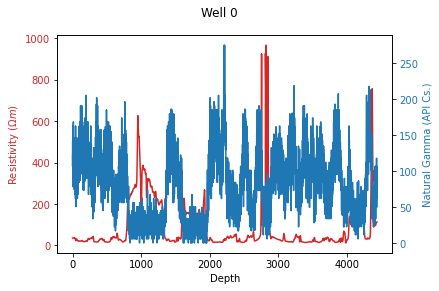

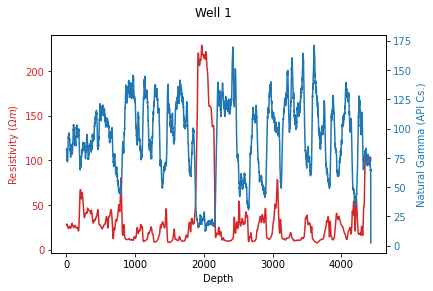

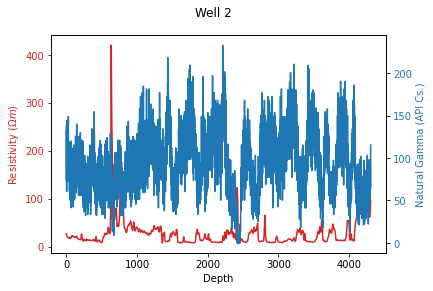

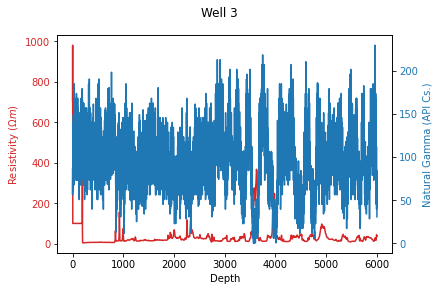

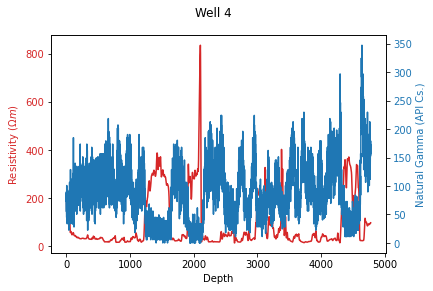

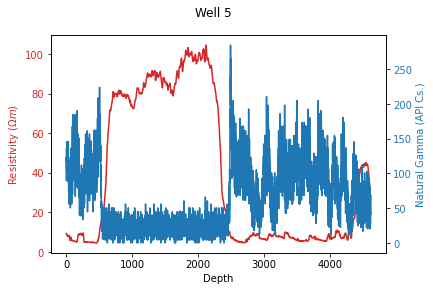

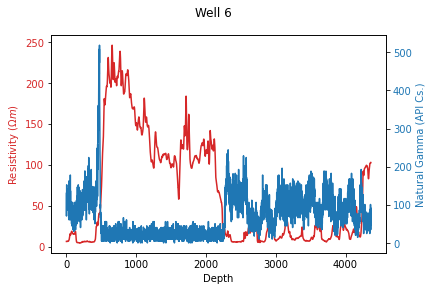

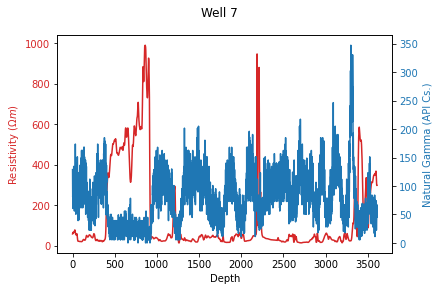

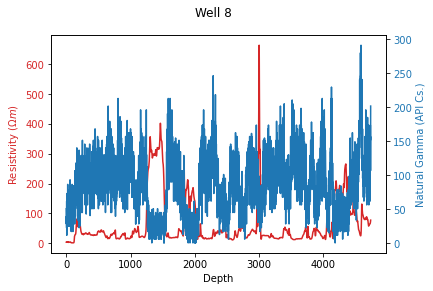

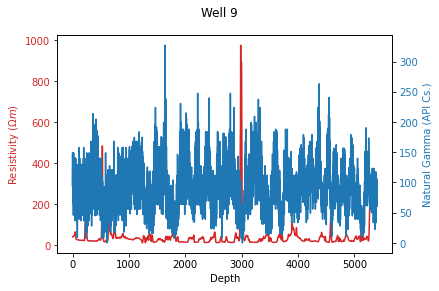

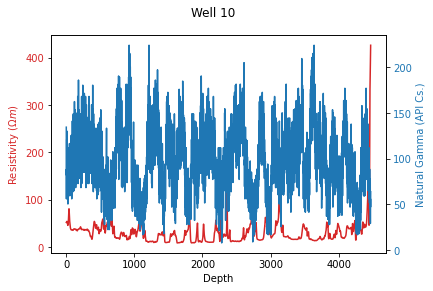

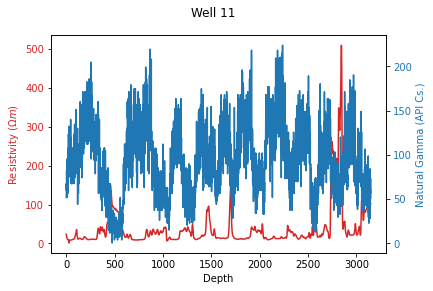

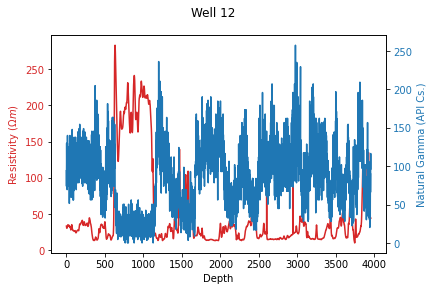

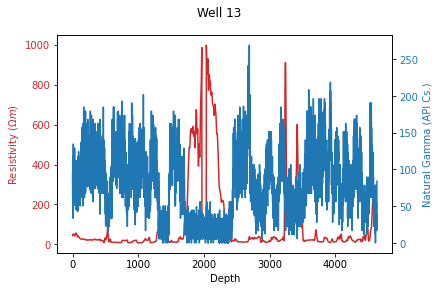

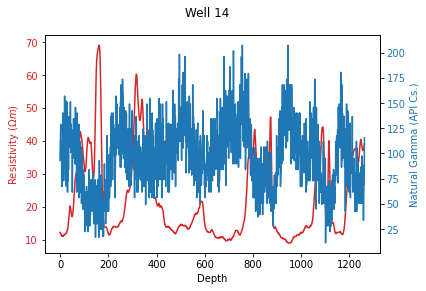

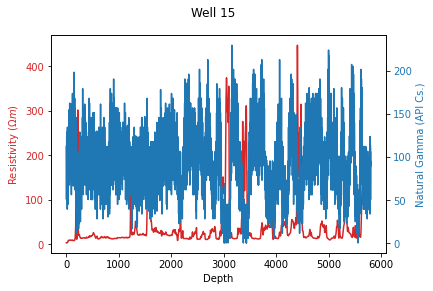

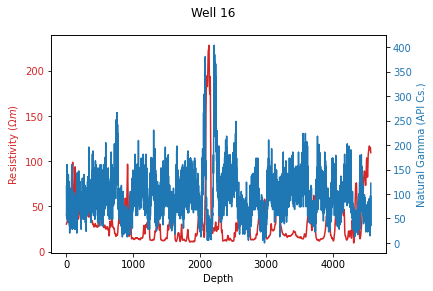

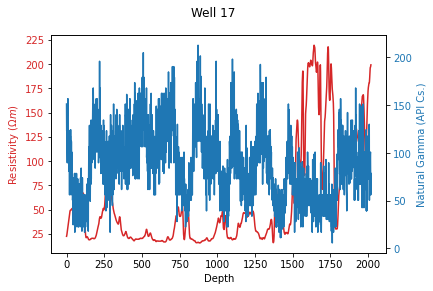

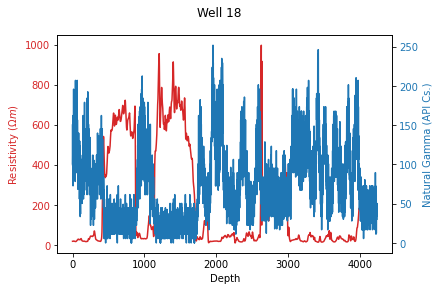

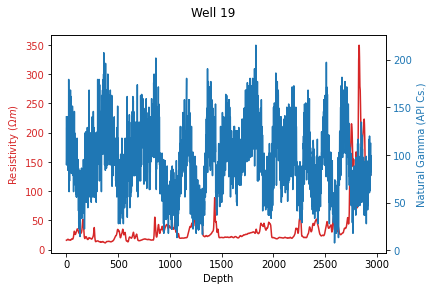

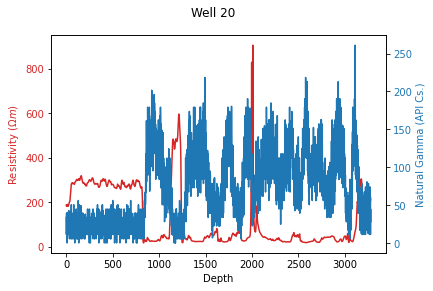

In [6]:
# Lets see some well data
# plot from https://matplotlib.org/3.5.0/gallery/subplots_axes_and_figures/two_scales.html

for i in range(21):
    data1 = list_x[i][:, 0]
    data2 = list_x[i][:, 1]

    fig, ax1 = plt.subplots()

    fig.suptitle(f'Well {i}')

    color = 'tab:red'
    ax1.set_xlabel('Depth')
    ax1.set_ylabel(r'Resistivity ($\Omega m$)', color=color)
    ax1.plot(data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Natural Gamma (API Cs.)', color=color)  # we already handled the x-label with ax1
    ax2.plot(data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



2022-05-16 10:01:27.108405: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-16 10:01:27.698822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11473 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 256)         16640     
                                                                 
 re_lu (ReLU)                (None, None, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 256)         2097408   
                                                                 
 re_lu_1 (ReLU)              (None, None, 256)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 256)         2097408   
                                                                 
 re_lu_2 (ReLU)              (None, None, 256)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 256)         2

2022-05-16 10:01:30.550015: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


1/1 - 3s - loss: 0.6915 - accuracy: 0.7431 - 3s/epoch - 3s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6901 - accuracy: 0.8023 - 328ms/epoch - 328ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.6856 - accuracy: 0.8165 - 269ms/epoch - 269ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.6808 - accuracy: 0.7601 - 278ms/epoch - 278ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.6752 - accuracy: 0.7270 - 236ms/epoch - 236ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.6585 - accuracy: 0.8165 - 184ms/epoch - 184ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.6184 - accuracy: 0.7475 - 146ms/epoch - 146ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.6151 - accuracy: 0.7930 - 248ms/epoch - 248ms/step
Epoch 9/1000
1/1 - 0s - loss: 0.6423 - accuracy: 0.6458 - 245ms/epoch - 245ms/step
Epoch 10/1000
1/1 - 0s - loss: 0.6057 - accuracy: 0.7377 - 297ms/epoch - 297ms/step
Epoch 11/1000
1/1 - 0s - loss: 0.6108 - accuracy: 0.6458 - 169ms/epoch - 169ms/step
Epoch 12/1000
1/1 - 0s - loss: 0.4666 - accuracy: 0.7921 - 275ms/epoch - 275ms/step
Epoch 13/1000
1/1 - 

/tmp/ipykernel_1634780/3067821360.py:241: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3, figsize=(16, 6))


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_240 (Conv1D)         (None, None, 256)         16640     
                                                                 
 re_lu_220 (ReLU)            (None, None, 256)         0         
                                                                 
 conv1d_241 (Conv1D)         (None, None, 256)         2097408   
                                                                 
 re_lu_221 (ReLU)            (None, None, 256)         0         
                                                                 
 conv1d_242 (Conv1D)         (None, None, 256)         2097408   
                                                                 
 re_lu_222 (ReLU)            (None, None, 256)         0         
                                                                 
 conv1d_243 (Conv1D)         (None, None, 256)       

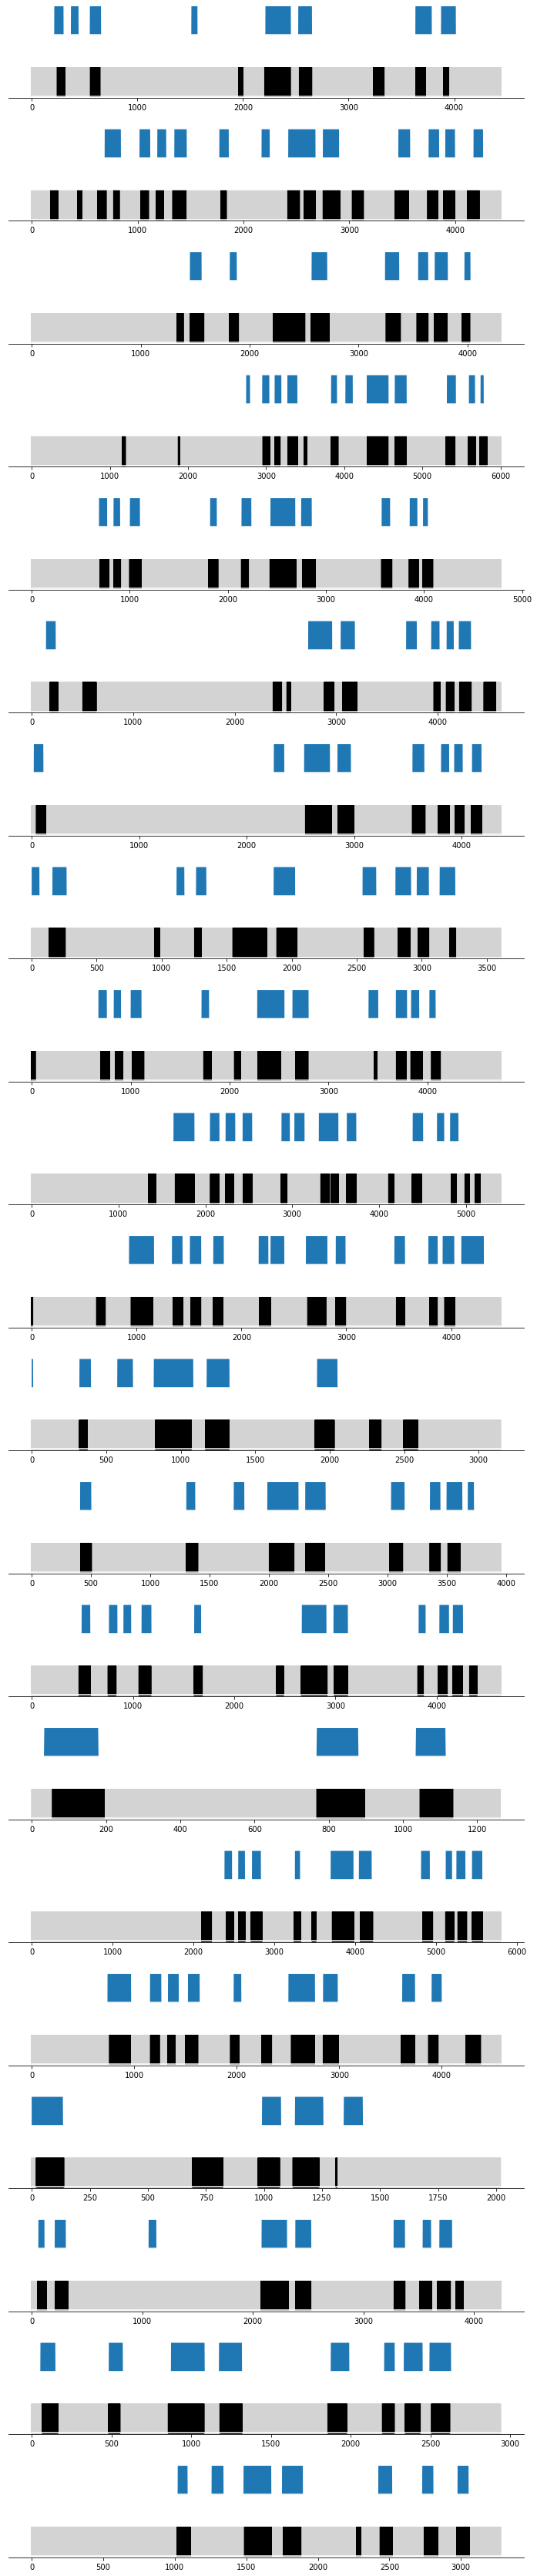

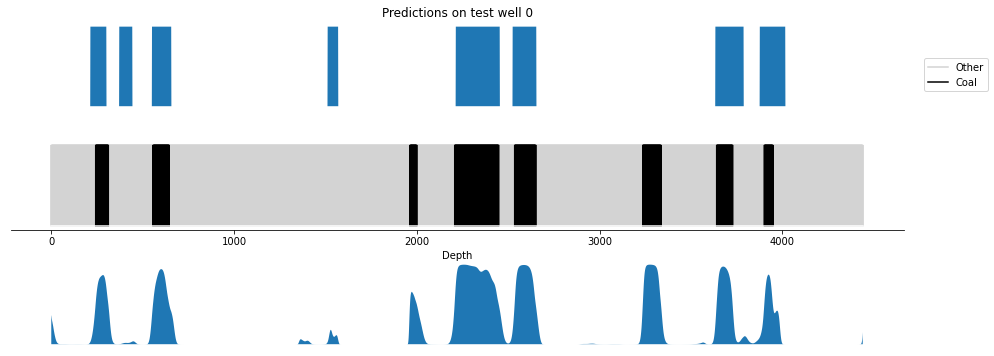

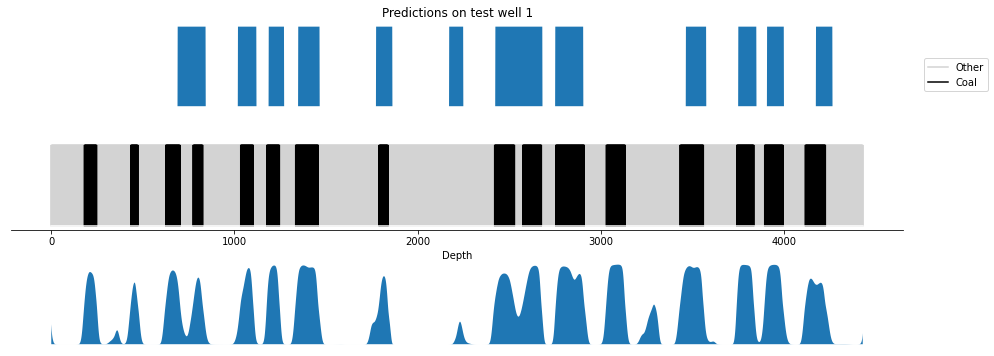

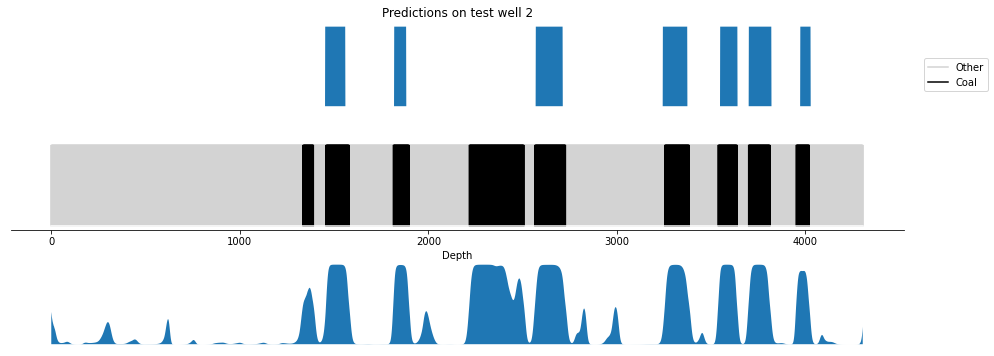

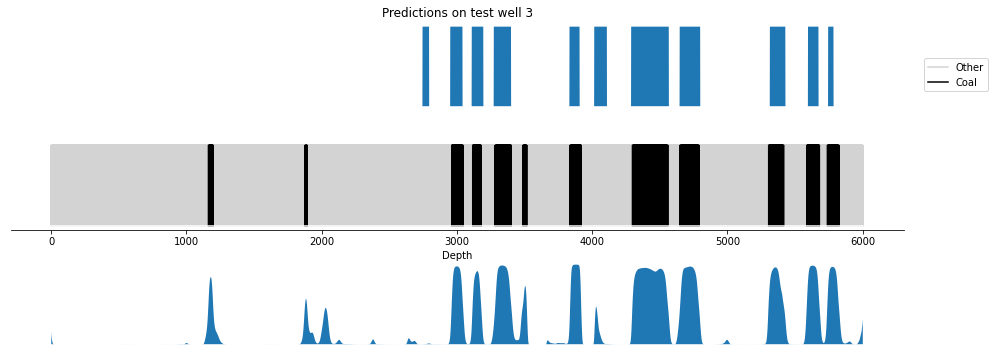

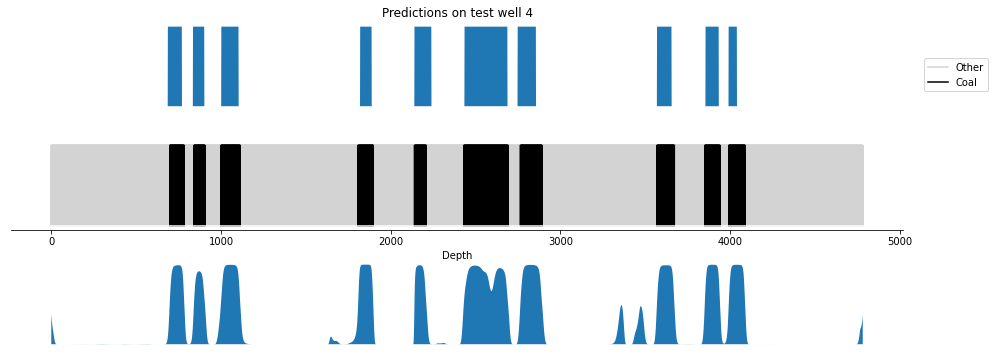

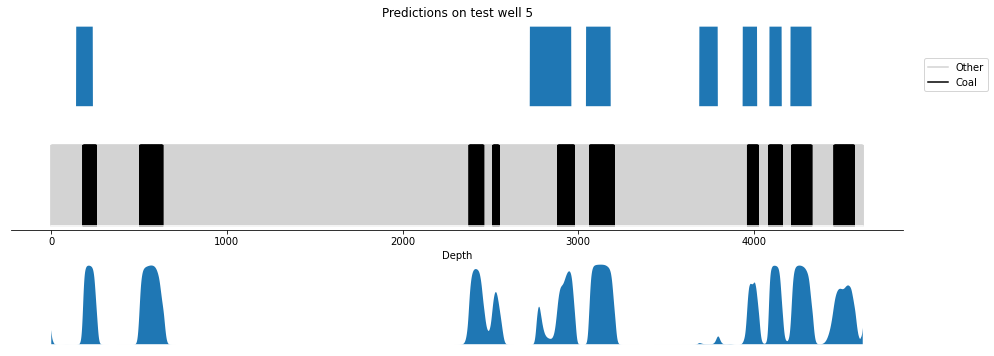

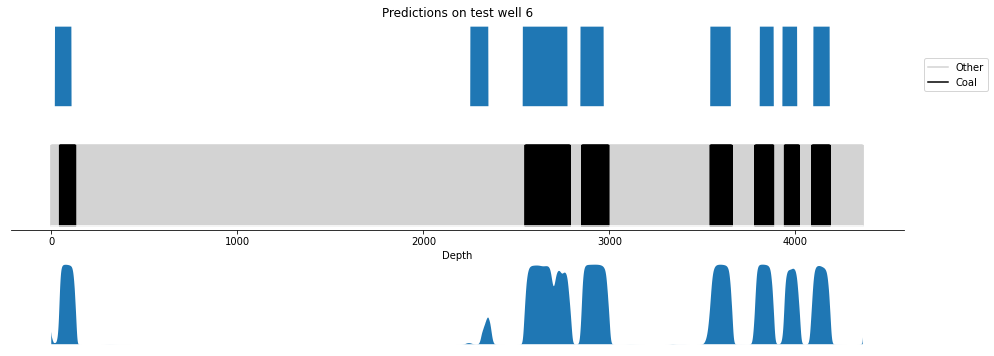

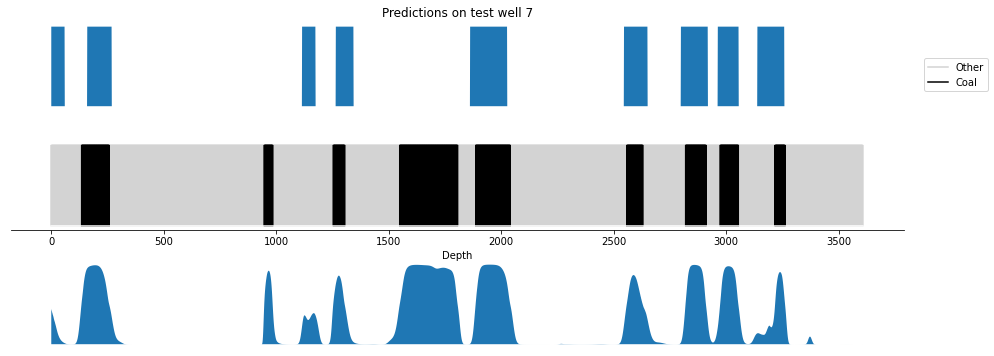

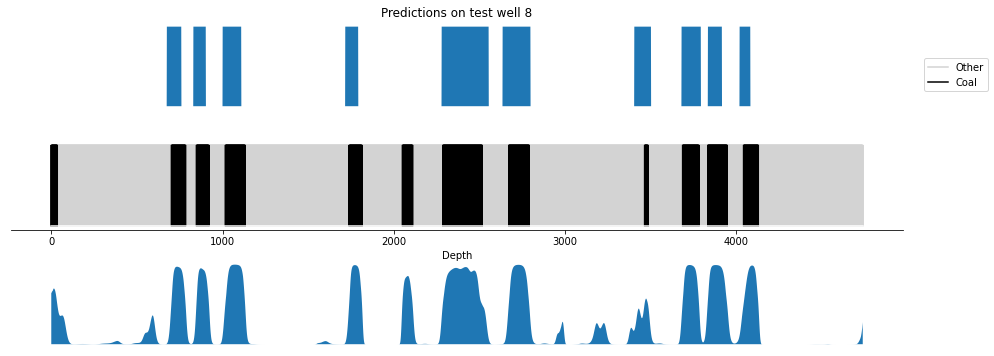

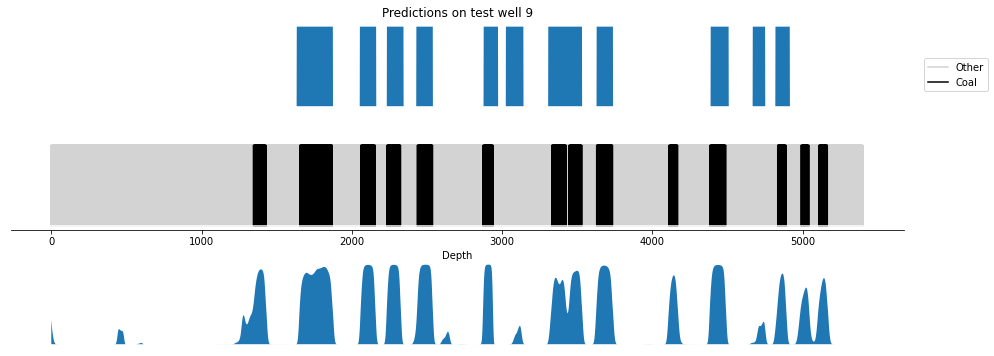

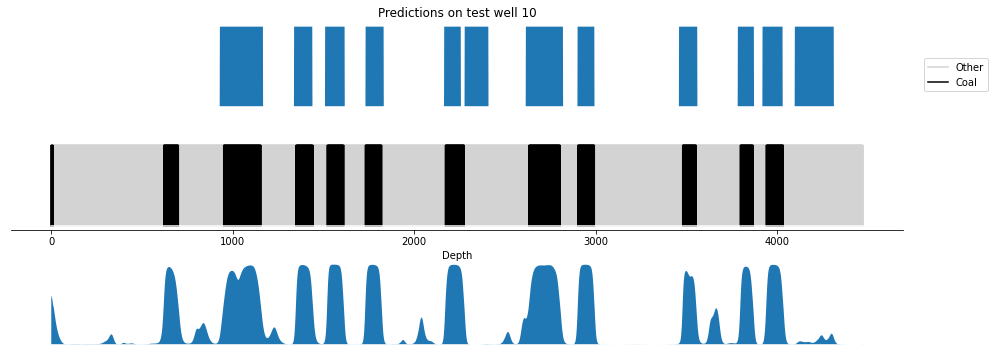

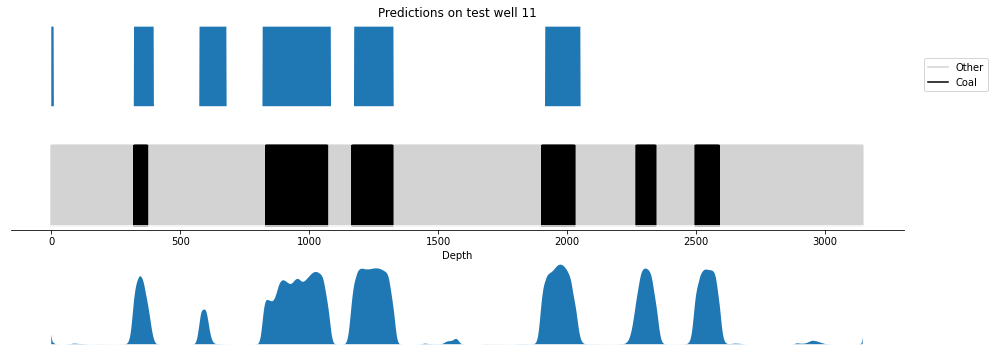

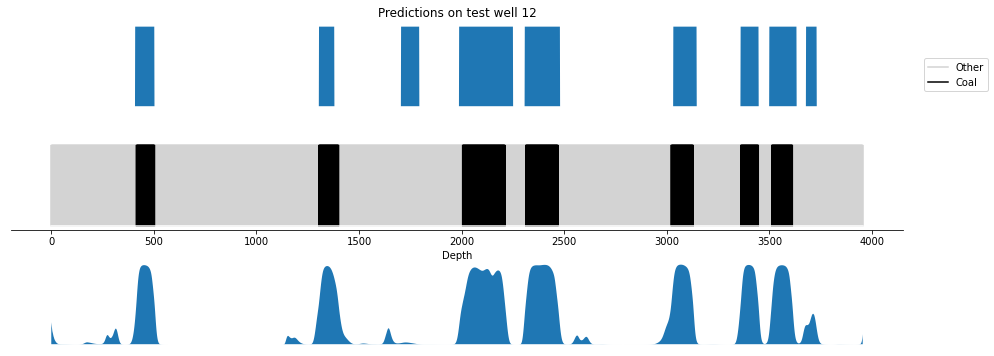

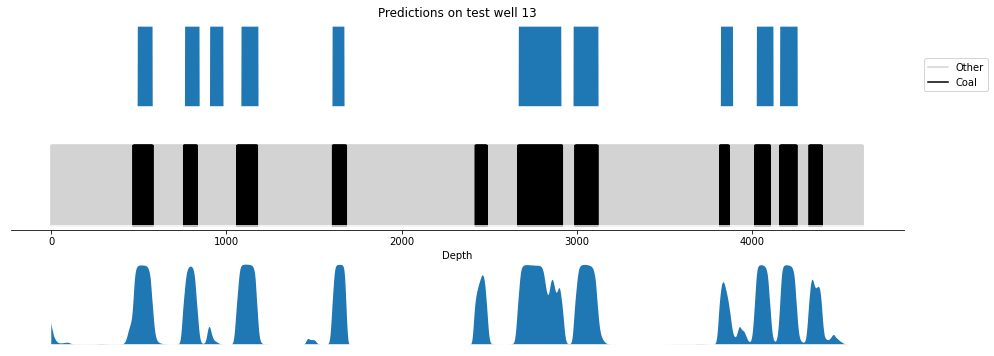

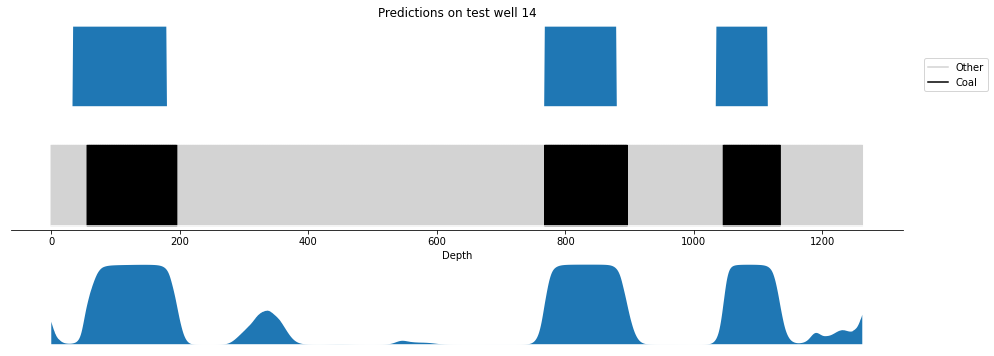

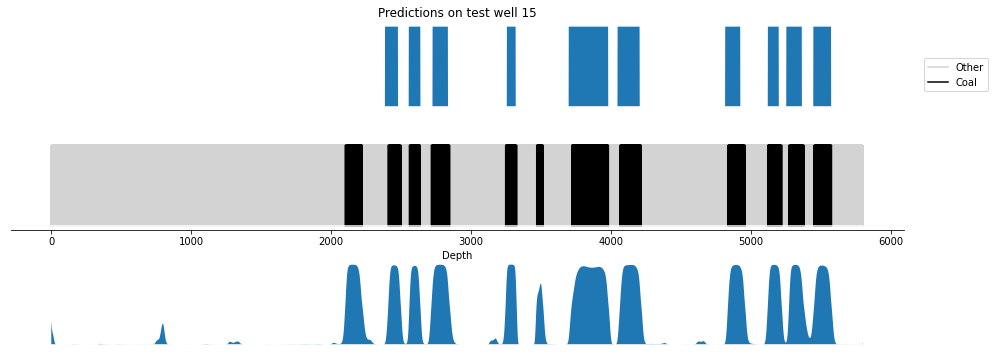

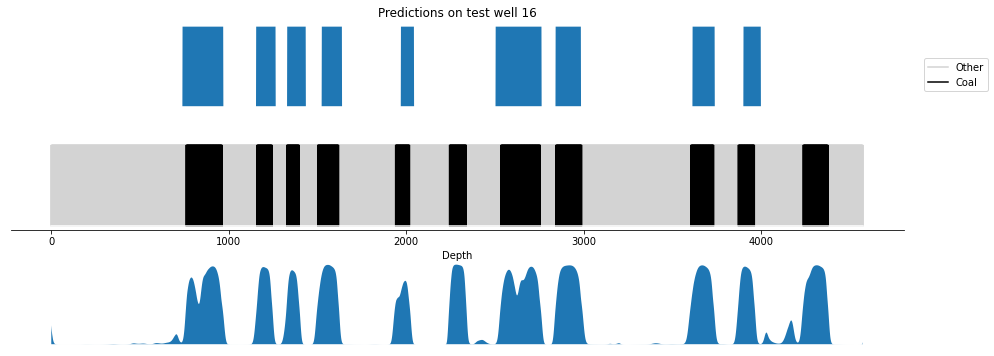

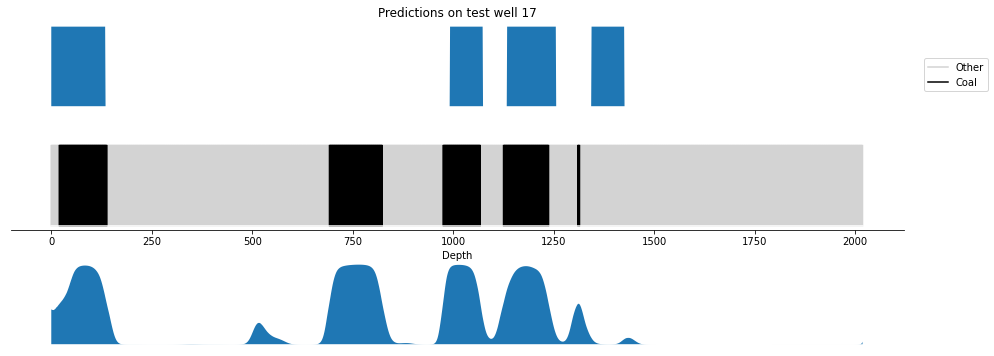

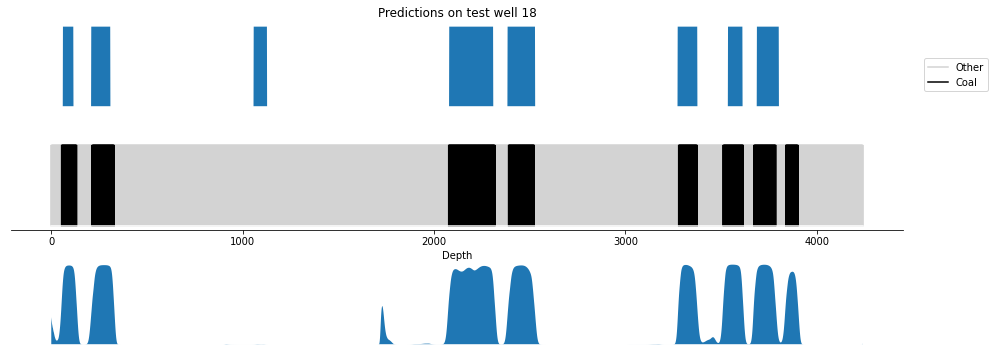

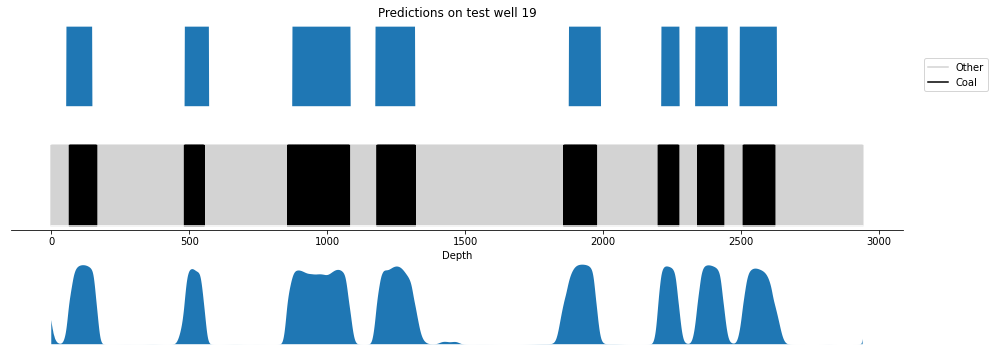

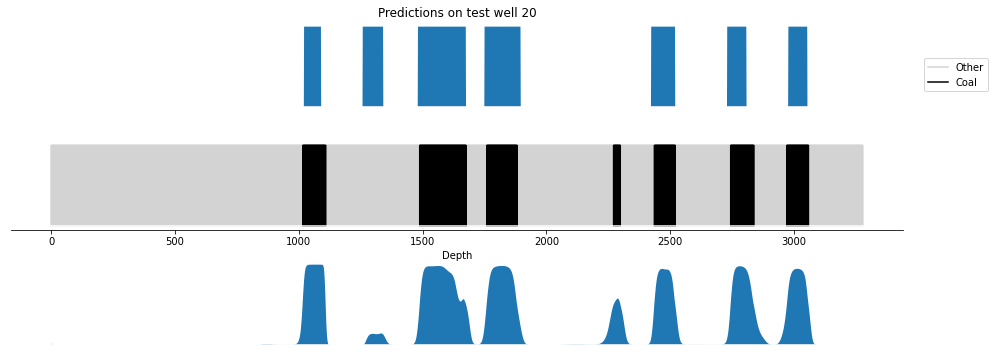

In [7]:
dict_table = {}

lst_f1_score = list()

# starting fig obj to plot all predictions on test sets
fig_all, axs_all = plt.subplots(2*len(list_x), figsize=(12, 2.9*len(list_x)))

# Here is the test well loop
# for each iteration, one well will be withdrawn to be test set
# for each iteration theres is a new FCN training
# for each iteration the model performance will be measured

for i_test in range(len(list_x)):

  # train
  list_x_train = list_x.copy()
  del list_x_train[i_test] # retire the test well
  list_y_train = list_y.copy()
  del list_y_train[i_test] # retire the test well
  
  col_means = np.vstack(list_x_train).mean(axis=0)
  col_stds = np.vstack(list_x_train).std(axis=0)

  # test well, standardize
  list_x_test = np.array(list_x.copy()[i_test])
  list_x_test = (list_x_test - col_means)/col_stds # standardize using training set parameters
  list_x_test = np.expand_dims(list_x_test, axis=0)[:, :, include_i]
  
  list_y_test = np.array(list_y.copy()[i_test])
  list_y_test = np.expand_dims(list_y_test, axis=0)
  
  # standardizing the training set inside generator
  gen = generator(list_x_train, list_y_train, include_i, col_means, col_stds, bool_class)


  input_shape = (None, None, include_i.size)


  model = Sequential()

  #
  model.add(Conv1D(filters, (kernel_size), padding='same', 
                   batch_input_shape=input_shape, 
                   strides=1, 
                   activation=None))

  for i in range(Nconv_layers):
    model.add(ReLU())
    model.add(Conv1D(filters, 
                     (kernel_size), 
                     padding='same', 
                     strides=1,
                     ))
    
    if i == Nconv_layers-2:
      model.add(Dropout(dropout_par))

  # Conv 1x1
  model.add(ReLU())

  # Conv 1x1
  if nclasses == 1:
    model.add(Conv1D(nclasses, (1), activation='sigmoid'))
  else:  
    model.add(Conv1D(nclasses, (1), activation='softmax'))


  optimizer = tf.keras.optimizers.Adam(
      learning_rate=0.00001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
  )


  if nclasses == 1:
    model.compile(loss='binary_crossentropy',
      optimizer = optimizer,
      metrics = ['accuracy'],
      )

  else:
    model.compile(loss='categorical_crossentropy',
      optimizer = optimizer,
      metrics = ['accuracy'],
      )

  print (model.summary())


  f = open(wkfolder+'/model_summary.txt', 'w')
  model.summary(print_fn=lambda x: f.write(x + '\n'))
  f.close()
  
  # make sure its a fresh starting model
  shuffle_weights(model, weights=None)

  model.fit(
      x=gen,
      #y=Y_train,
      #batch_size=1,
      epochs=epochs,
      verbose=2,
      #callbacks=None,
      #validation_split=0.0,
      #validation_data=(list_x_test, list_y_test),
      #shuffle=True,
      #class_weight=None,
      #sample_weight=None,
      #initial_epoch=0,
      steps_per_epoch=1,
      #validation_steps=1,
      #validation_batch_size=None,
      #validation_freq=1,
      #max_queue_size=10,
      #workers=1,
      #use_multiprocessing=False,
  )
    
  X_test = list_x_test
  Y_test = list_y_test

  pred = model.predict(X_test)
  
  
  ### figure with the result of a given test well 
  if bool_class == False: # caso multiclasse
    fig, axs = plt.subplots(3, figsize=(13, 6))

    # first ax
    for i in range(nclasses):
      axs[0].fill_between(range(len(Y_test[0, :, i])), Y_test[0, :, i], y2=0, color=dict_colors[i])
      axs_all[2*i_test].fill_between(range(len(Y_test[0, :, i])), Y_test[0, :, i], y2=0, color=dict_colors[i])
    axs[0].axis('off')
    axs[0].set_title('Predictions on test well {}'.format(i_test))
    # white line
    axs[0].plot([0, len(Y_test[0, :, i])], 
                [0, 0], 
                color='white',
                ) 
    axs_all[2*i_test].plot([0, len(Y_test[0, :, i])], 
                [0, 0], 
                color='white',
                linewidth=1,
                ) 
    axs_all[2*i_test].axis('off')
    
    # sec. ax
    for i in range(nclasses):
      pred_vec = pred[0, :, i]
      axs[1].fill_between(range(len(pred_vec)), pred_vec, y2=0, color=dict_colors[i],)

    axs[1].plot([0, len(Y_test[0, :, i])], 
                [0, 0], 
                color='white',
                ) 
    axs[1].yaxis.set_visible(False)
    axs[1].spines['bottom'].set_color('black')
    axs[1].spines['top'].set_color('white') 
    axs[1].spines['right'].set_color('white')
    axs[1].spines['left'].set_color('white')

    # third ax
    max_class = pred[0, :, :].argmax(axis=1)
    map_colors = [dict_colors[i] for i in max_class]
    map_labels = [dict_names[i] for i in max_class]
    
    y_test_max_class = Y_test[0, :, :].argmax(axis=1)
    
    # all classification metrics for each test well 
    file = open(wkfolder+f'/classification_report_poco_{i_test}.txt', 'w')
    file.write(classification_report(y_test_max_class, max_class))
    file.close()

    d =  classification_report(y_test_max_class, max_class, output_dict=True)

    dict_table[i_test] = {}
    
    for i in range(nclasses):
      if d.get(str(i)):
        dict_table[i_test][i] = d[str(i)]['f1-score']
        if d[str(i)]['support'] == 0:
          dict_table[i_test][i] = -1
      else: # nao tem classe i
        dict_table[i_test][i] = -1


    lst_f1_score.append(classification_report(y_test_max_class, max_class, 
                                              output_dict=True)['macro avg']['f1-score'])
    
    for i_classe in np.unique(max_class):
    
      idxs_classe = max_class == i_classe
    
      x_dom = np.arange(len(pred_vec))[idxs_classe]
      y_dom = np.zeros(x_dom.size) + 1 # 1
      
      color = dict_colors[i_classe]
      label = dict_names[i_classe]
      
      #axs[2].fill_between(x_dom, y_dom, y2=0, color=color, label=label)
      X, Y = [], []
      for x in x_dom:
        X.extend([x, x, None])
        Y.extend([0, 1, None])
      axs[2].plot(X, Y, color, label=label)
      axs_all[2*i_test+1].plot(X, Y, color, label=label)
    
    axs[2].plot([0, len(Y_test[0, :, i])], 
                [0, 0], 
                color='white',
                ) 
    axs_all[2*i_test+1].plot([0, len(Y_test[0, :, i])], 
                [0, 0], 
                color='white',
                ) 
      
    axs[2].legend(bbox_to_anchor=(1.1, 2.0))
    #axs[2].set_xlabel('Depth')
    axs[2].axis('off')
    axs_all[2*i_test+1].set_xlabel('Depth')

    axs_all[2*i_test+1].plot([0, len(Y_test[0, :])], 
                [0, 0], 
                color='white',
                )     
    axs_all[2*i_test+1].yaxis.set_visible(False)
    axs_all[2*i_test+1].spines['bottom'].set_color('black')
    axs_all[2*i_test+1].spines['top'].set_color('white') 
    axs_all[2*i_test+1].spines['right'].set_color('white')
    axs_all[2*i_test+1].spines['left'].set_color('white')



    fig.savefig(wkfolder + '/test_2_poco_{}.png'.format(i_test))


  else: # binary case

    fig, axs = plt.subplots(3, figsize=(16, 6))

    # primeiro eixo
    axs[0].fill_between(range(len(Y_test[0, :])), Y_test[0, :], y2=0)
    axs[0].set_title('Predictions on test well {}'.format(i_test))
    axs_all[2*i_test].fill_between(range(len(Y_test[0, :])), Y_test[0, :], y2=0)
    
    # white line
    axs[0].plot([0, len(Y_test[0, :])], 
                [0, 0], 
                color='white',
                ) 
    axs[0].axis('off')
    axs_all[2*i_test].plot([0, len(Y_test[0, :])], 
                [0, 0], 
                color='white',
                ) 
    axs_all[2*i_test].axis('off')

    # third ax [yes]
    pred_vec = pred[0, :, 0]
    axs[2].fill_between(range(len(pred_vec)), pred_vec, y2=0,)# color=dict_colors[i],)

    axs[2].plot([0, len(Y_test[0, :])], 
                [0, 0], 
                color='white',
                ) 
    axs[2].axis('off')

    # sec. ax
    pred = pred[0, :, 0] 
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    
    file = open(wkfolder+f'/classification_report_binary_poco_{i_test}.txt', 'w')
    file.write(classification_report(Y_test[0, :], pred))
    file.close()
    
    d = classification_report(Y_test[0, :], pred, output_dict=True)

    dict_table[i_test] = {}
    
    for i in range(2):
      if d.get(str(i)):
        dict_table[i_test][i] = d[str(i)]['f1-score']
        if d[str(i)]['support'] == 0:
          dict_table[i_test][i] = -1
      else: # nao tem classe i
        dict_table[i_test][i] = -1


    lst_f1_score.append(classification_report(Y_test[0, :], pred, output_dict=True)['macro avg']['f1-score'])

    # o fundo
    X, Y = [], []
    x_dom = np.arange(len(pred_vec))

    for x in x_dom:
      X.extend([x, x, None])
      Y.extend([0, 1, None])
    axs[1].plot(X, Y, 'lightgray', label='Other')
    axs_all[2*i_test+1].plot(X, Y, 'lightgray', label='Other')


    # plit coal indicator    
    idxs = pred == 1
    x_dom = np.arange(len(pred_vec))[idxs]
    
    color = 'black' #dict_colors[i_classe]
    label = 'Coal' #dict_names[i_classe]
    
    X, Y = [], []
    for x in x_dom:
      X.extend([x, x, None])
      Y.extend([0, 1, None])
    axs[1].plot(X, Y, color, label=label)
    axs_all[2*i_test+1].plot(X, Y, color, label=label)

    
    #
    axs[1].plot([0, len(Y_test[0, :])], 
                [0, 0], 
                color='white',
                ) 
    axs[1].legend(bbox_to_anchor=(1.1, 2.0))
    axs[1].set_xlabel('Depth')
    
    axs[1].yaxis.set_visible(False)
    axs[1].spines['bottom'].set_color('black')
    axs[1].spines['top'].set_color('white') 
    axs[1].spines['right'].set_color('white')
    axs[1].spines['left'].set_color('white')
    
    axs_all[2*i_test+1].plot([0, len(Y_test[0, :])], 
                [0, 0], 
                color='white',
                )     
    axs_all[2*i_test+1].yaxis.set_visible(False)
    axs_all[2*i_test+1].spines['bottom'].set_color('black')
    axs_all[2*i_test+1].spines['top'].set_color('white') 
    axs_all[2*i_test+1].spines['right'].set_color('white')
    axs_all[2*i_test+1].spines['left'].set_color('white')
    
    # agora grava
    #plt.tight_layout()
    fig.subplots_adjust(hspace=0.35)
    fig.savefig(wkfolder + '/test_2_poco_{}.png'.format(i_test))


# legenda manual

if bool_class == False: # vamos fazer uma legenda maual para o caso multiclasse
  l_names = sorted(list(dict_names.values()))
  l_names.remove('Other') # isso aqui é pra deixar o 'Other' no fim
  l_names.append('Other')

  l_patches = []
  for name in l_names:
    key_ = search_key_by_value(dict_names, name)
    color = dict_colors[key_]
    l_patches.append(mpatches.Patch(color=color, label=name))
  fig_all.legend(handles=l_patches)
  fig_all.legend(bbox_to_anchor=(1.1, 2.0))

fig_all.subplots_adjust(hspace=0.95)
fig_all.savefig(wkfolder + '/todos_pocos.png')


file = open(wkfolder+f'/macro_avg_f1_score.txt', 'w')
file.write(f'vector: {lst_f1_score}\n')
file.write(f'mean: {np.mean(lst_f1_score)}')
file.write(f'std: {np.std(lst_f1_score)}')
file.close()


# dict table for latex
# well id & class 1 & class 2 & class 3 & ...
# 0 & .1 & .2 & .3 & ...
l_string = ''.join(['l' for x in range(nclasses+1)]) # nclasses + well id column

s = f'\\begin{{tabular}}{{{l_string}}}\n'
s = s + '\\hline\\noalign{\\smallskip}\n'

s = s + 'id'
for i in range(nclasses):
  s = s + f'& {dict_names[i]}'
  

s = s + '\\\\ \n'
s = s + '\\hline\\noalign{\\smallskip}\n'

dict_f1_values_all_wells = {}
for i in range(nclasses): # estabelecer a ordem de aparição das classes
  dict_f1_values_all_wells[i] = list()
# colocar os valores/linhas agora
for key, value in dict_table.items():
  s = s + f'{key}'
  for i in range(nclasses): # estabelecer a ordem de aparição das classes
    s = s + f'& {dict_table[key].get(i):.2f}'
    if dict_table[key].get(i) >= 0:
      dict_f1_values_all_wells[i].append(dict_table[key].get(i))
    
  s = s + '\\\\ \n'

# ultima linha com as medias
s = s + 'all'
for i in range(nclasses): # estabelecer a ordem de aparição das classes
  s = s + f'& {np.mean(dict_f1_values_all_wells[i]):.2f}'
s = s + '\\\\ \n'


s = s.replace('-1.00', '-')

print (s)

file = open(wkfolder+f'/latex_table1.txt', 'w')
file.write(s)
file.close()




